<a href="https://colab.research.google.com/github/LeoTU911/SCC413/blob/main/VAE_1.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Wed Feb 15 00:15:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    46W / 400W |   3094MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
!git clone https://github.com/LeoTU911/SCC413

Cloning into 'SCC413'...
remote: Enumerating objects: 405, done.
remote: Counting objects: 100% (114/114), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 405 (delta 4), reused 113 (delta 3), pack-reused 291
Receiving objects: 100% (405/405), 6.57 MiB | 13.94 MiB/s, done.
Resolving deltas: 100% (8/8), done.


In [ ]:
#!ls -R

In [2]:
import os
import tensorflow as tf
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import backend as K
from keras.layers import Input, Dense, Lambda, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose
from keras.models import Model
from PIL import Image

In [ ]:
datadir = '/content/SCC413/CUHK_training_cropped_photos'
datadir = pathlib.Path(datadir)

rawData = tf.data.Dataset.list_files(str(datadir/'*'))

BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

def img2data(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels = 3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

trainImage = rawData.map(img2data, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# test
for i in trainImage.take(5):
  print(i.numpy())

[[[3.5686275e-01 7.4509805e-01 8.7058830e-01]
  [3.5686275e-01 7.4509805e-01 8.7058830e-01]
  [3.5686275e-01 7.4509805e-01 8.7058830e-01]
  ...
  [4.5518222e-04 1.1537116e-02 0.0000000e+00]
  [4.5518222e-04 1.1537116e-02 0.0000000e+00]
  [4.5518222e-04 1.1537116e-02 0.0000000e+00]]

 [[3.5686275e-01 7.4509805e-01 8.7058830e-01]
  [3.5686275e-01 7.4509805e-01 8.7058830e-01]
  [3.5686275e-01 7.4509805e-01 8.7058830e-01]
  ...
  [9.2086848e-03 6.4775911e-03 6.1449599e-03]
  [9.2086848e-03 6.4775911e-03 6.1449599e-03]
  [9.2086848e-03 6.4775911e-03 6.1449599e-03]]

 [[3.5686275e-01 7.4509805e-01 8.7058830e-01]
  [3.5686275e-01 7.4509805e-01 8.7058830e-01]
  [3.5769591e-01 7.4593121e-01 8.7142146e-01]
  ...
  [1.1134451e-02 3.4138684e-03 5.0087549e-02]
  [1.1134451e-02 3.4138684e-03 5.0087549e-02]
  [1.1134451e-02 3.4138684e-03 5.0087549e-02]]

 ...

 [[8.8007712e-01 8.5705543e-01 7.9164922e-01]
  [8.9281625e-01 8.6979455e-01 8.0014193e-01]
  [8.8506562e-01 8.5880107e-01 7.8787392e-01]
  ..

In [ ]:
print(datadir)
type(datadir)

/content/SCC413/CUHK_training_cropped_photos


pathlib.PosixPath

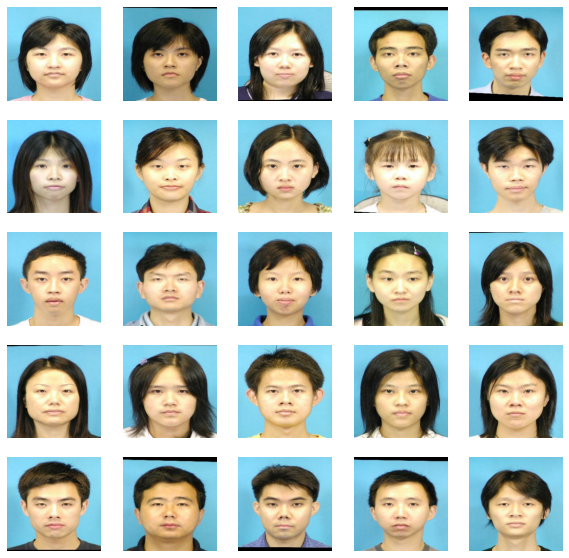

In [ ]:
def prepare_Training(data, cache = True, shuffle_buffer_size = 1000):
  if cache:
    if isinstance(cache, str):
      data = data.cache(cache)
    else:
      data = data.cache()
  
  data = data.shuffle(buffer_size = shuffle_buffer_size)
  data = data.repeat()
  data = data.batch(BATCH_SIZE)

  data = data.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)

  return data

def show_batch(img_batch):
  plt.figure(figsize=(10,10))
  for i in range(25):
    ax = plt.subplot(5,5,i+1)
    plt.imshow(img_batch[i])
    plt.axis('off')

trainingData = prepare_Training(trainImage)
image_batch = next(iter(trainingData))

show_batch(image_batch.numpy())

In [24]:
#image to grayscale image
filePath1 = '/content/SCC413/CUHK_training_cropped_photos'
filePath2 = '/content/SCC413/CUHK_testing_cropped_photos'


def img2GSimg(filePath):
  images = []

  for fileName in os.listdir(filePath):
    if fileName.endswith('.jpg'):
      img_tmp = Image.open(os.path.join(filePath, fileName)).convert('L')
      img_tmp = img_tmp.resize((64, 64))
      img_array = np.array(img_tmp)
      images.append(img_array)
  return images

images = img2GSimg(filePath1)
images2 = img2GSimg(filePath2)

x_train = np.array(images).reshape((-1, 64, 64, 1)).astype('float32') / 255.
x_test = np.array(images2).reshape((-1, 64, 64, 1)).astype('float32') / 255.

In [25]:
print(x_train.shape)
print(x_test.shape)

(88, 64, 64, 1)
(100, 64, 64, 1)


In [30]:
# 定义VAE模型
input_shape = (64, 64, 1)
batch_size = 1
latent_dim = 32
epochs = 80

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# 编码器
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
x = Conv2D(32, 3, padding='same', activation='LeakyReLU')(x)
x = Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = Conv2D(128, 3, padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)
x = Flatten()(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# 解码器
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(np.prod(shape_before_flattening[1:]), activation='relu')(latent_inputs)
x = Reshape(shape_before_flattening[1:])(x)
x = Conv2DTranspose(128, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = Conv2D(1, 3, padding='same', activation='sigmoid')(x)

decoder = Model(latent_inputs, x, name='decoder')
decoder.summary()

# VAE模型
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

# 损失函数
reconstruction_loss = K.mean(K.binary_crossentropy(inputs, outputs))
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d_55 (Conv2D)             (None, 64, 64, 32)   320         ['encoder_input[0][0]']          
                                                                                                  
 conv2d_56 (Conv2D)             (None, 32, 32, 64)   18496       ['conv2d_55[0][0]']              
                                                                                                  
 conv2d_57 (Conv2D)             (None, 32, 32, 64)   36928       ['conv2d_56[0][0]']              
                                                                                            

In [31]:
# 训练模型
# vae.fit(x_train, epochs=epochs, batch_size=batch_size)
vae.fit(x_train, 
    x_train,
    epochs=100,
    batch_size=32,
    validation_data=(x_test, x_test))

# plot
plt.plot(vae.history.history["loss"])
plt.plot(vae.history.history["val_loss"])

Epoch 1/100
1/3 [=========>....................] - ETA: 5s - loss: 0.7161

InvalidArgumentError: ignored

3/3 [==============================] - 0s 3ms/step


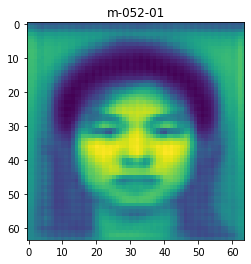

3/3 [==============================] - 0s 3ms/step


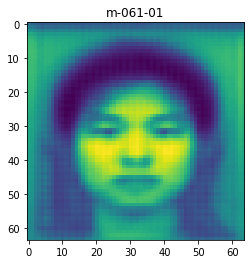

3/3 [==============================] - 0s 2ms/step


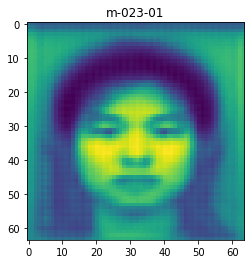

3/3 [==============================] - 0s 3ms/step


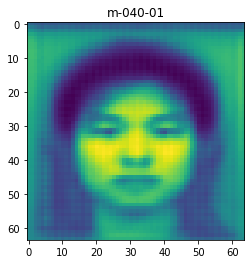

3/3 [==============================] - 0s 3ms/step


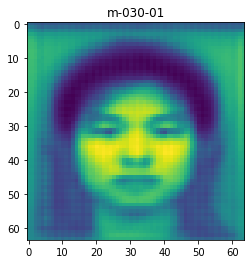

3/3 [==============================] - 0s 3ms/step


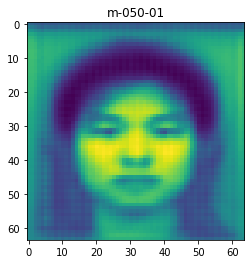

3/3 [==============================] - 0s 3ms/step


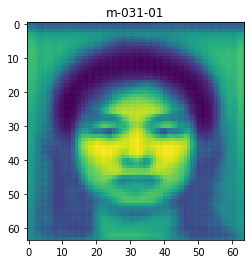

3/3 [==============================] - 0s 2ms/step


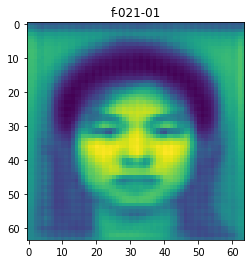

3/3 [==============================] - 0s 2ms/step


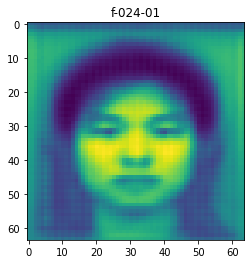

3/3 [==============================] - 0s 2ms/step


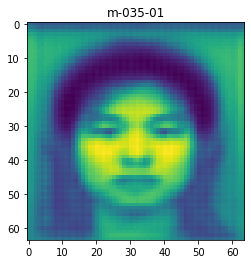

3/3 [==============================] - 0s 2ms/step


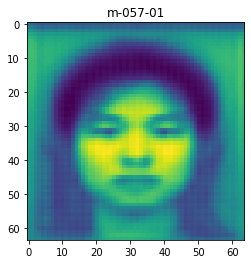

3/3 [==============================] - 0s 3ms/step


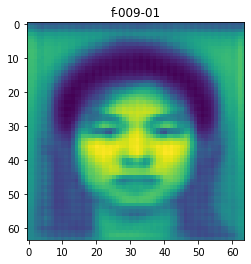

3/3 [==============================] - 0s 2ms/step


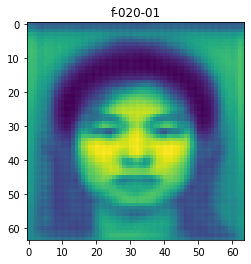

3/3 [==============================] - 0s 2ms/step


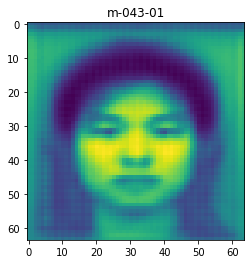

3/3 [==============================] - 0s 2ms/step


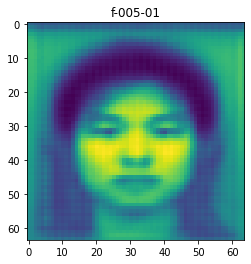

3/3 [==============================] - 0s 3ms/step


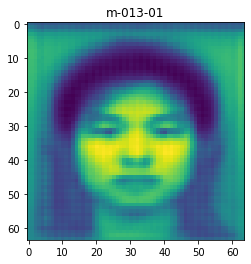

3/3 [==============================] - 0s 3ms/step


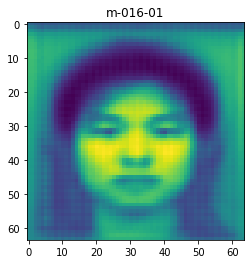

3/3 [==============================] - 0s 3ms/step


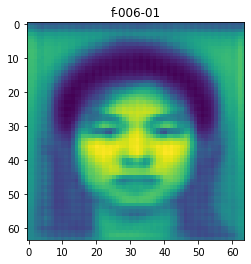

3/3 [==============================] - 0s 3ms/step


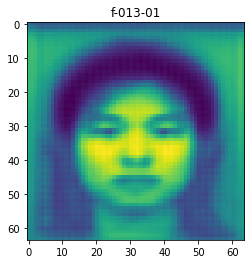

3/3 [==============================] - 0s 2ms/step


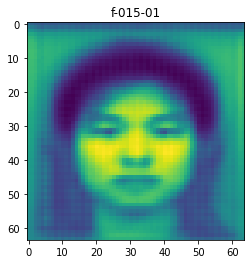

3/3 [==============================] - 0s 3ms/step


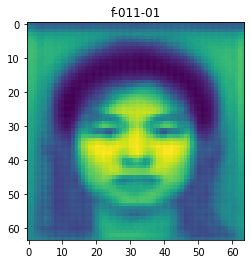

3/3 [==============================] - 0s 3ms/step


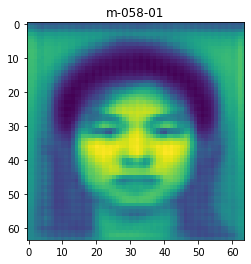

3/3 [==============================] - 0s 3ms/step


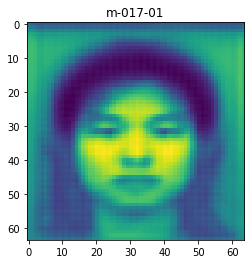

3/3 [==============================] - 0s 2ms/step


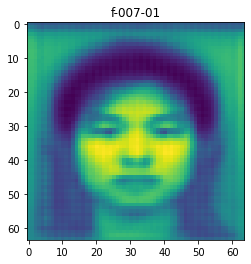

3/3 [==============================] - 0s 3ms/step


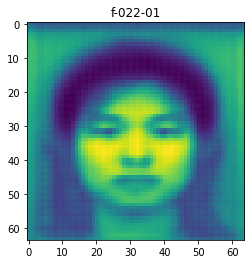

3/3 [==============================] - 0s 2ms/step


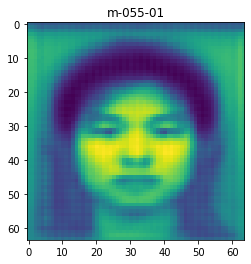

3/3 [==============================] - 0s 3ms/step


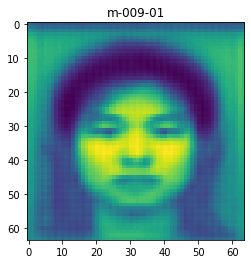

3/3 [==============================] - 0s 2ms/step


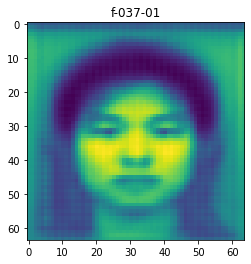

3/3 [==============================] - 0s 2ms/step


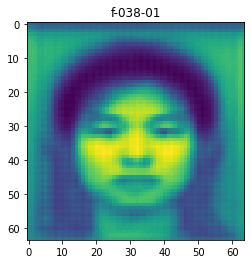

3/3 [==============================] - 0s 3ms/step


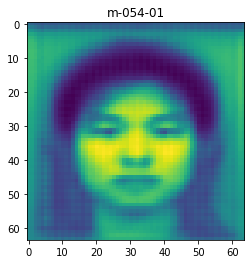

3/3 [==============================] - 0s 3ms/step


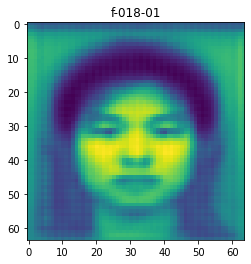

3/3 [==============================] - 0s 3ms/step


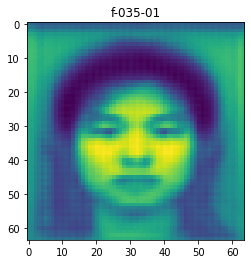

3/3 [==============================] - 0s 3ms/step


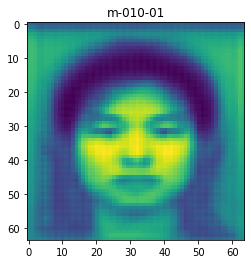

3/3 [==============================] - 0s 3ms/step


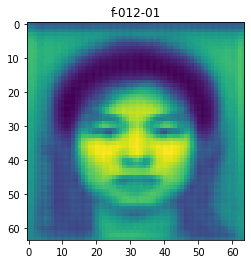

3/3 [==============================] - 0s 3ms/step


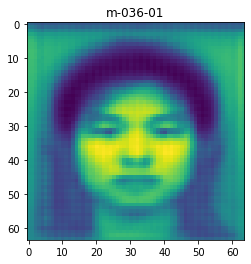

3/3 [==============================] - 0s 2ms/step


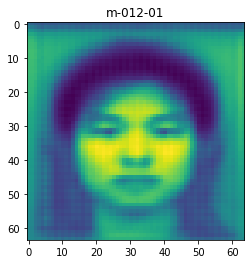

3/3 [==============================] - 0s 3ms/step


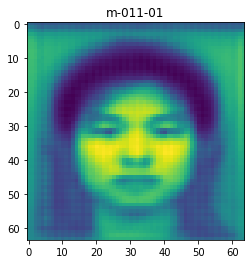

3/3 [==============================] - 0s 3ms/step


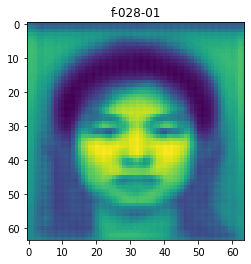

3/3 [==============================] - 0s 2ms/step


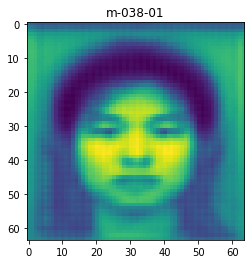

3/3 [==============================] - 0s 3ms/step


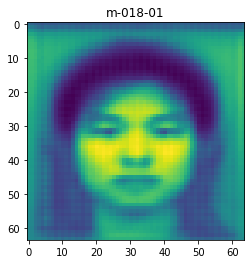

3/3 [==============================] - 0s 3ms/step


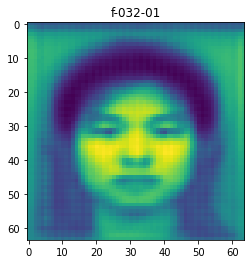

3/3 [==============================] - 0s 2ms/step


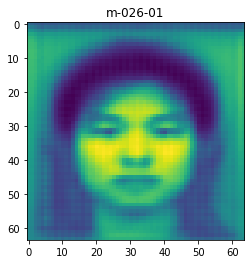

3/3 [==============================] - 0s 2ms/step


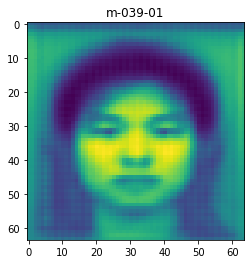

3/3 [==============================] - 0s 3ms/step


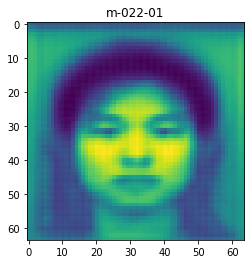

3/3 [==============================] - 0s 3ms/step


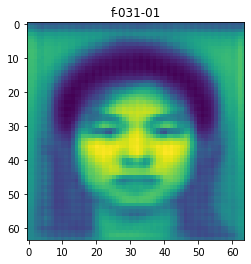

3/3 [==============================] - 0s 3ms/step


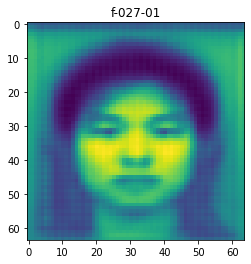

3/3 [==============================] - 0s 3ms/step


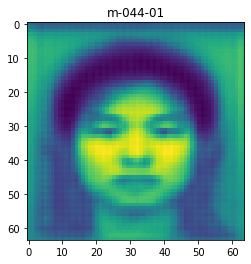

3/3 [==============================] - 0s 3ms/step


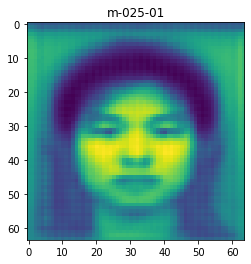

3/3 [==============================] - 0s 3ms/step


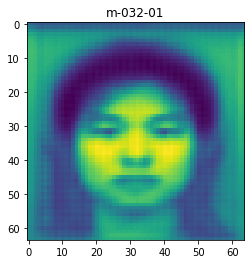

3/3 [==============================] - 0s 2ms/step


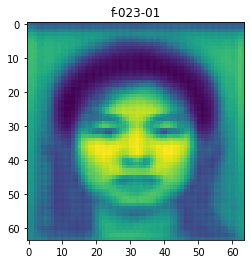

3/3 [==============================] - 0s 3ms/step


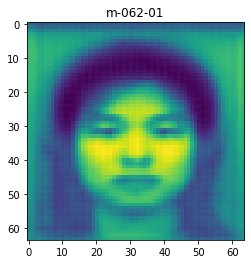

3/3 [==============================] - 0s 3ms/step


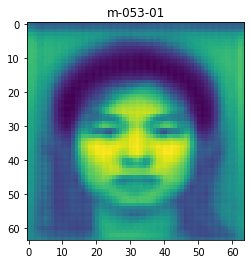

3/3 [==============================] - 0s 3ms/step


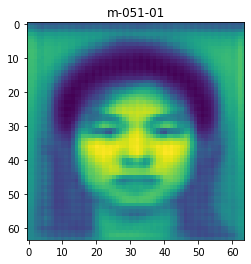

3/3 [==============================] - 0s 3ms/step


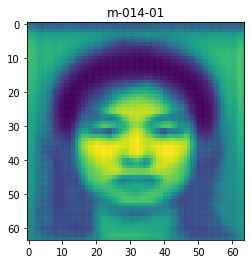

3/3 [==============================] - 0s 3ms/step


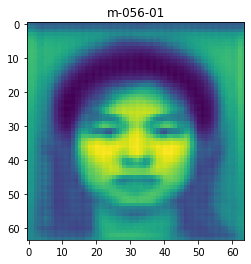

3/3 [==============================] - 0s 3ms/step


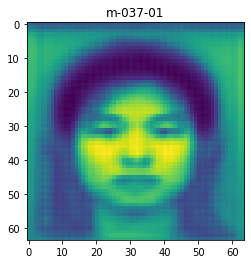

3/3 [==============================] - 0s 3ms/step


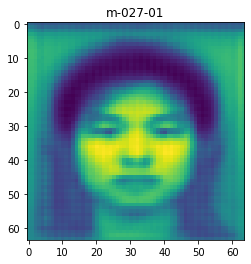

3/3 [==============================] - 0s 3ms/step


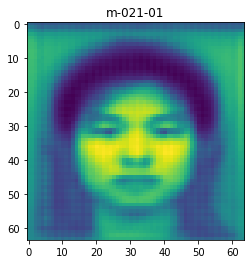

3/3 [==============================] - 0s 2ms/step


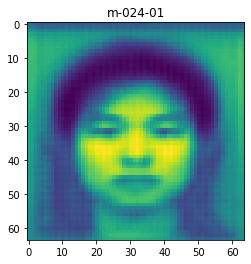

3/3 [==============================] - 0s 2ms/step


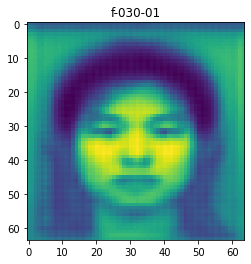

3/3 [==============================] - 0s 3ms/step


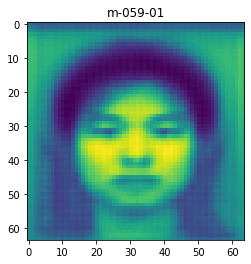

3/3 [==============================] - 0s 3ms/step


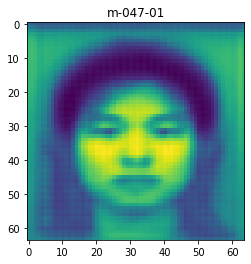

3/3 [==============================] - 0s 3ms/step


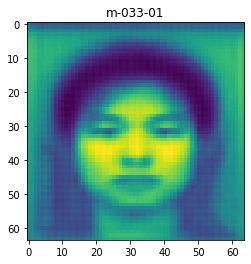

3/3 [==============================] - 0s 3ms/step


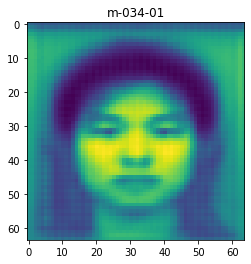

3/3 [==============================] - 0s 3ms/step


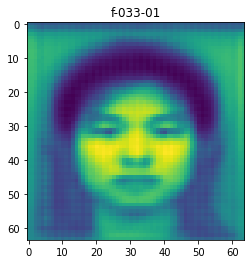

3/3 [==============================] - 0s 3ms/step


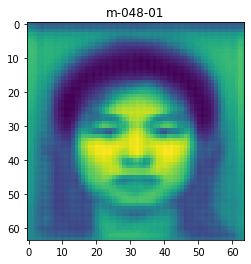

3/3 [==============================] - 0s 2ms/step


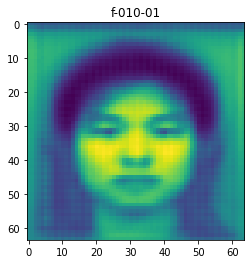

3/3 [==============================] - 0s 2ms/step


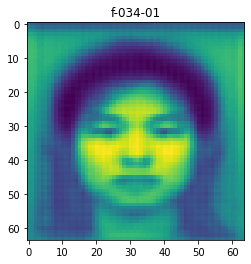

3/3 [==============================] - 0s 2ms/step


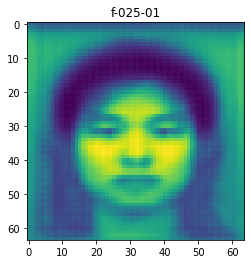

3/3 [==============================] - 0s 3ms/step


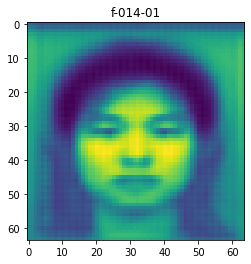

3/3 [==============================] - 0s 2ms/step


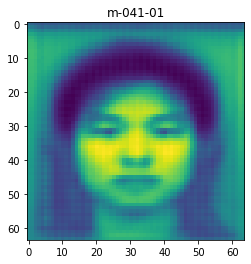

3/3 [==============================] - 0s 2ms/step


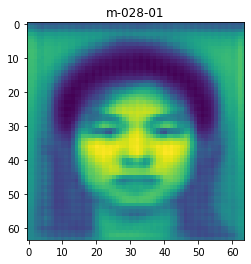

3/3 [==============================] - 0s 3ms/step


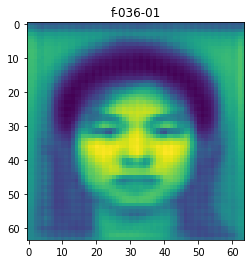

3/3 [==============================] - 0s 3ms/step


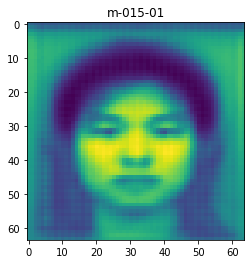

3/3 [==============================] - 0s 3ms/step


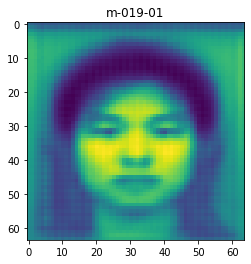

3/3 [==============================] - 0s 2ms/step


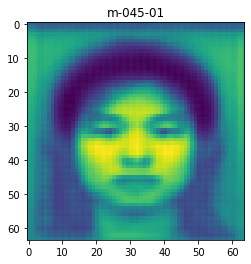

3/3 [==============================] - 0s 2ms/step


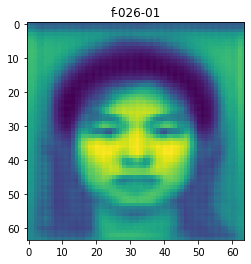

3/3 [==============================] - 0s 3ms/step


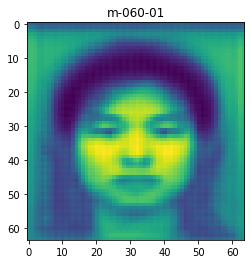

3/3 [==============================] - 0s 3ms/step


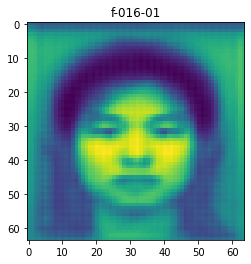

3/3 [==============================] - 0s 3ms/step


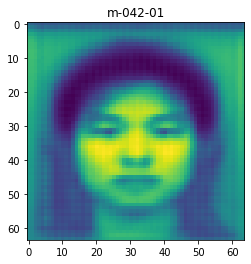

3/3 [==============================] - 0s 2ms/step


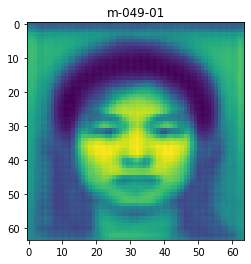

3/3 [==============================] - 0s 3ms/step


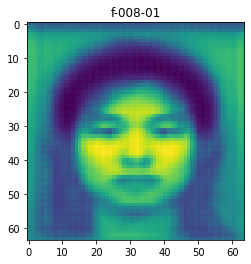

3/3 [==============================] - 0s 3ms/step


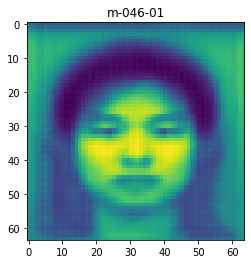

3/3 [==============================] - 0s 2ms/step


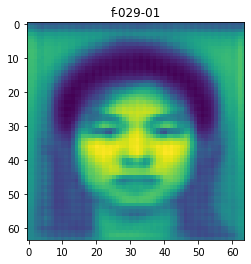

3/3 [==============================] - 0s 3ms/step


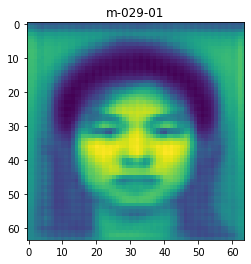

3/3 [==============================] - 0s 3ms/step


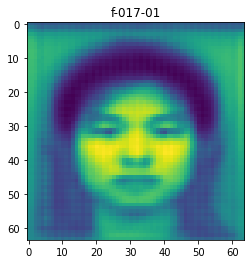

3/3 [==============================] - 0s 3ms/step


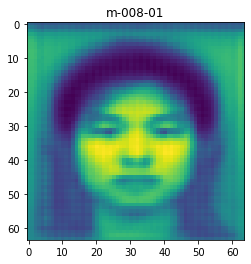

3/3 [==============================] - 0s 3ms/step


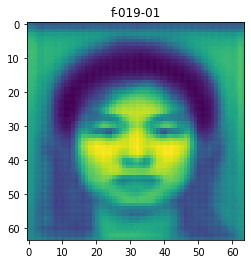

In [29]:
# 使用VAE模型生成素描图片
for fileName in os.listdir(filePath1):
    # 读取输入图片
    img_tmp = Image.open(os.path.join(filePath1, fileName)).convert('L')
    
    # 转换为模型的输入格式
    img_tmp = img_tmp.resize((128, 128))
    img_tmp = np.array(img_tmp).reshape((1,128,128,1)).astype('float32') / 255.

    # 使用VAE模型生成素描图片
    z_mean, _, _ = encoder.predict(x_train, batch_size=batch_size)
    sketch_img = decoder.predict(z_mean)

    # 转换为PIL Image格式并保存为文件
    sketch_img = sketch_img[0] * 255.
    #sketch_img = np.clip(sketch_img, 0, 255).astype('uint8')
    sketch_img = sketch_img.astype('uint8').reshape((*sketch_img.shape[:-1],))
    sketch_img = Image.fromarray(sketch_img)
    #sketch_filename = os.path.splitext(fileName)[0] + "_predSketch.jpg"
    #sketch_img.save(os.path.join(filePath, sketch_filename))

    # 显示生成的素描图片
    plt.imshow(sketch_img)
    plt.title(os.path.splitext(fileName)[0])
    plt.show()